## Solving the CIFAR Dataset

So moving on from the basic linear regression problem, in this notebook we are going to improvise on CIFAR-10 Dataset classification problem by utilizing Pytorch.

Now, we need to understand Pytorch is a tensor framework and can't handle images in their original form and has a separate library called torchvision to handle images.

Lets import the packages.

In [32]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

Now, one cool thing about torchvision is that it itself has a horde of datasets, with Cifar-10 being one of them. We are going to load the dataset from there and also transform the images into tensors so that it can be handled by Pytorch.

One more thing the CIFAR Dataset is RGB in color. For now we are going to utilize only Grayscale images hence we are going to transform them to grayscale.

In [10]:
image_transform = transforms.Compose([transforms.Grayscale(num_output_channels = 1),
                                     transforms.ToTensor()])

In [11]:
cifa_data = CIFAR10(root = '/data',
                    transform = image_transform,
                    train = True,
                    download = True
                   )

Files already downloaded and verified


Okay! So, the dataset is here.

Lets check its length and see one of its elements.

In [12]:
len(cifa_data)

50000

In [13]:
x, y = cifa_data[0]

print(x.shape)
print(y)

torch.Size([1, 32, 32])
6


Okay, so the dataset is of 50,000 images of shape 32 * 32. 

Its always awesome to visualize one of the pictures before moving ahead. 

For that we are going to utilize the <code>plt.imshow()</code> function.

The Label is : 9


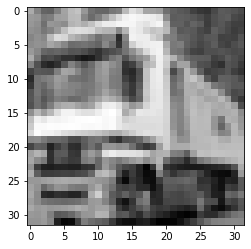

In [17]:
img , label = cifa_data[1]
img = img.reshape(32 , 32)
plt.imshow(img , cmap  ='gray')
print('The Label is :', label)

Okay, it seems like a truck.

It is quite evident the images are quite small, but its easier for storage and manipulation.

Now lets create our model.

It will be very simple model with linear layer outputting the output of 10units.

Lets do that.

In [20]:
class cifar_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1024 , 10)
        
    def forward(self , x):
        x = x.reshape(-1 , 1024)
        out = self.linear(x)
        return out
    
cif_model = cifar_model() #instantiating cifar model

In [39]:
list(cif_model.parameters())

[Parameter containing:
 tensor([[-0.0057, -0.0047, -0.0063,  ..., -0.0207,  0.0124, -0.0301],
         [ 0.0040, -0.0235, -0.0031,  ...,  0.0213, -0.0303, -0.0191],
         [ 0.0068,  0.0217, -0.0194,  ..., -0.0085, -0.0061,  0.0147],
         ...,
         [-0.0019,  0.0029, -0.0167,  ..., -0.0115,  0.0095,  0.0308],
         [ 0.0273,  0.0267, -0.0241,  ..., -0.0243,  0.0146,  0.0098],
         [-0.0133, -0.0176, -0.0057,  ..., -0.0310, -0.0110, -0.0208]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0026, -0.0042, -0.0016, -0.0147, -0.0009, -0.0236, -0.0118, -0.0266,
         -0.0279, -0.0114], requires_grad=True)]

Now with the model set, it is essential to split the dataset into training and validation. For validation we are going to keep 10% of the data.

Lets create a function to pick out the indexes of validation and training sets.

In [27]:
def train_val_split(total_len , val_percent):
    val_range = int(total_len * val_percent)
    shuffled_idx =  np.random.permutation(total_len)
    return shuffled_idx[: val_range] , shuffled_idx[val_range: ]

In [28]:
total_len = len(cifa_data)
val_percent = 0.10

val_idx , train_idx = train_val_split(total_len , val_percent)

Lets check the validation and training length.

In [29]:
print(len(val_idx))
print(len(train_idx))

5000
45000


Yes! Everything is sorted. Now what we do is we set our dataloader with more random samplings.

In [34]:
train_sampler = SubsetRandomSampler(train_idx)
train_dl = DataLoader(cifa_data , batch_size = 512 , sampler = train_sampler)

val_sampler = SubsetRandomSampler(val_idx)
val_dl = DataLoader(cifa_data , batch_size = 512 , sampler = val_sampler)

Now its time to set our loss function and optimizer.

In [37]:
loss_func = torch.nn.functional.cross_entropy  ##setting the loss function

In [40]:
optim = torch.optim.SGD(cif_model.parameters() , lr = 1e-3)

Now we need to set a metric to validate our model. So we are going to define accuracy function here.

In [41]:
def accuracy(predicted_val , target):
    _,pred = torch.max(predicted_val , axis = 1)
    return torch.sum(pred == target).item() / len(target)   

Now its time to train our model.

In [45]:
def fit(model , epochs, dl , loss_func , optim , metric = None):
    
    for epoch in range(epochs):
        
        for x , y in dl:
            
            ##generate predictions
            pred = model(x)
            
            ##calculate loss function
            loss = loss_func(pred , y)
            
            ##one step of backpropagation
            loss.backward()
            
            ##one step of optimization
            optim.step()
            
            ##reset the gradients to zero
            optim.zero_grad()
            
        if metric is not None:
            acc = accuracy(pred , y)
            print('Epochs : {} , Loss : {:.4f} , Accuracy : {:.4f}'.format(epoch + 1 , loss , acc))
        else:
            print('Epochs : {} , Loss : {:.4f}'.format(epoch + 1 , loss))

In [47]:
fit(cif_model , 100, train_dl , loss_func , optim , metric = 'accuracy')

Epochs : 1 , Loss : 2.2170 , Accuracy : 0.2259
Epochs : 2 , Loss : 2.2097 , Accuracy : 0.2127
Epochs : 3 , Loss : 2.2132 , Accuracy : 0.1886
Epochs : 4 , Loss : 2.1890 , Accuracy : 0.1952
Epochs : 5 , Loss : 2.1917 , Accuracy : 0.2083
Epochs : 6 , Loss : 2.1831 , Accuracy : 0.1996
Epochs : 7 , Loss : 2.1930 , Accuracy : 0.2346
Epochs : 8 , Loss : 2.1817 , Accuracy : 0.2346
Epochs : 9 , Loss : 2.1924 , Accuracy : 0.2018
Epochs : 10 , Loss : 2.1737 , Accuracy : 0.2171
Epochs : 11 , Loss : 2.1621 , Accuracy : 0.2412
Epochs : 12 , Loss : 2.1530 , Accuracy : 0.2303
Epochs : 13 , Loss : 2.1682 , Accuracy : 0.2083
Epochs : 14 , Loss : 2.1421 , Accuracy : 0.2215
Epochs : 15 , Loss : 2.1597 , Accuracy : 0.2149
Epochs : 16 , Loss : 2.1646 , Accuracy : 0.2018
Epochs : 17 , Loss : 2.1476 , Accuracy : 0.2259
Epochs : 18 , Loss : 2.1488 , Accuracy : 0.2281
Epochs : 19 , Loss : 2.1491 , Accuracy : 0.2237
Epochs : 20 , Loss : 2.1228 , Accuracy : 0.2303
Epochs : 21 , Loss : 2.1465 , Accuracy : 0.2215
E

Boom! I know the accuracy is bad, but for now its okay!

We won't be doing the validation and the testing in this notebook, just for simplicity purpose!